## Reference [Setup](https://github.com/daekeun-ml/genai-ko-LLM/blob/main/fine-tuning/0_setup.ipynb)

## Install dependencies

In [2]:
!pip install -r requirements.txt

  Using cached peft-0.7.1-py3-none-any.whl.metadata (25 kB)
  Using cached accelerate-0.25.0-py3-none-any.whl.metadata (18 kB)
  Using cached transformers-4.36.2-py3-none-any.whl.metadata (126 kB)
  Using cached bitsandbytes-0.41.3-py3-none-any.whl.metadata (9.8 kB)
  Using cached datasets-2.16.0-py3-none-any.whl.metadata (20 kB)
  Using cached wandb-0.16.3-py3-none-any.whl.metadata (9.9 kB)
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
  Using cached xxhash-3.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached GitPython-3.1.41-py3-none-any.whl.metadata (14 kB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl (9.0 kB)
  Using cached setproctitle-1.3.3-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.9 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
  Using cached gitdb-4.0.11-py3-none-any.whl.metadata (1.2 kB)
INFO: pip is looking at mult

In [3]:
!pip install -qU boto3 botocore huggingface_hub sagemaker langchain deepspeed wandb

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.32.33 requires botocore==1.34.33, but you have botocore 1.34.40 which is incompatible.
datasets 2.16.0 requires dill<0.3.8,>=0.3.0, but you have dill 0.3.8 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.1.1 which is incompatible.
sphinx 7.2.6 requires docutils<0.21,>=0.18.1, but you have docutils 0.16 which is incompatible.


## Change Docker image path to EBS

SageMaker 노트북 인스턴스에서 로컬 모드 디버깅 시 종종 No space left 관련 오류가 발생합니다. 따라서, 도커 이미지/컨테이너가 저장될 폴더를 SageMaker EBS (Amazon Elastic Block Store) 볼륨으로 변경하는 것을 권장합니다. 도커 이미지/컨테이너는 기본적으로 EBS가 아닌 루트 볼륨에 저장하기 때문에(루트 볼륨의 크기는 사용자가 임의로 조정할 수 없습니다!) 고용량의 이미지들을 빌드하면 용량이 꽉 차기 때문입니다.

In [4]:
%%bash

#!/usr/bin/env bash

echo '{
    "runtimes": {
        "nvidia": {
            "path": "nvidia-container-runtime",
            "runtimeArgs": []
        }
    }
}' > daemon.json

sudo cp daemon.json /etc/docker/daemon.json && rm daemon.json

DAEMON_PATH="/etc/docker"
MEMORY_SIZE=10G

FLAG=$(cat $DAEMON_PATH/daemon.json | jq 'has("data-root")')
# echo $FLAG

if [ "$FLAG" == true ]; then
    echo "Already revised"
else
    echo "Add data-root and default-shm-size=$MEMORY_SIZE"
    sudo cp $DAEMON_PATH/daemon.json $DAEMON_PATH/daemon.json.bak
    sudo cat $DAEMON_PATH/daemon.json.bak | jq '. += {"data-root":"/home/ec2-user/SageMaker/.container/docker","default-shm-size":"'$MEMORY_SIZE'"}' | sudo tee $DAEMON_PATH/daemon.json > /dev/null
    sudo service docker restart
    echo "Docker Restart"
fi

sudo docker info | grep Root

Add data-root and default-shm-size=10G


Redirecting to /bin/systemctl restart docker.service


Docker Restart
 Docker Root Dir: /home/ec2-user/SageMaker/.container/docker


# [Preprocess Datasets for Korean LLM (Large Language Model) fine-tuning](https://github.com/daekeun-ml/genai-ko-LLM/blob/main/fine-tuning/1_prepare-dataset-chunk-method.ipynb)

- [AWS 기술 블로그](https://aws.amazon.com/ko/blogs/tech/train-a-large-language-model-on-a-single-amazon-sagemaker-gpu-with-hugging-face-and-lora/)에서 전처리했던 방식대로 전처리 수행

- 허깅페이스 인증 정보 설정: huggingface-cli login

https://huggingface.co/join

https://huggingface.co/settings/tokens

### Download LLM from Hugging Face hub

Load dataset

허깅페이스 허브에서 다운로드하거나 json/json 포맷의 데이터 세트를 다운로드합니다. 데이터 세트 내 샘플은 (instruction, input, output)의 key-value나 (instruction, output)의 key-value로 구성되어야 합니다.

예시:

{
    "instruction":"건강을 유지하기 위한 세 가지 팁을 알려주세요.",
    "input":"",
    "output":"세 가지 팁은 아침식사를 꼭 챙기며, 충분한 수면을 취하고, 적극적으로 운동을 하는 것입니다."
}

In [1]:
import os
import torch
import transformers
from datasets import load_dataset

data_path = "beomi/KoAlpaca-v1.1a"
#data_path = "./data/ko_alpaca_data.json"

if data_path.endswith(".json") or data_path.endswith(".jsonl"):
    data = load_dataset("json", data_files=data_path)
else:
    data = load_dataset(data_path)


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from inference_lib import Prompter

In [3]:
prompter = Prompter("kullm")

In [4]:
import os
from pathlib import Path
from huggingface_hub import snapshot_download
from transformers import GPTNeoXForCausalLM, GPTNeoXTokenizerFast

HF_MODEL_ID = "nlpai-lab/kullm-polyglot-12.8b-v2"

tokenizer = GPTNeoXTokenizerFast.from_pretrained(HF_MODEL_ID)

# Only download pytorch checkpoint files
allow_patterns = ["*.json", "*.pt", "*.bin", "*.txt", "*.model"]

# create model dir
model_name = HF_MODEL_ID.split("/")[-1].replace('.', '-')
model_tar_dir = Path(f"/home/ec2-user/SageMaker/models/{model_name}")
if not os.path.isdir(model_tar_dir):
    os.makedirs(model_tar_dir, exist_ok=True)
    # Download model from Hugging Face into model_dir
    snapshot_download(
        HF_MODEL_ID, 
        local_dir=str(model_tar_dir), 
        local_dir_use_symlinks=False,
        allow_patterns=allow_patterns,
        cache_dir="/home/ec2-user/SageMaker/"
    )

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'GPTN

In [5]:
# 데이터셋의 처음 3개 샘플을 출력
print(data['train'][:3])

{'instruction': ['양파는 어떤 식물 부위인가요? 그리고 고구마는 뿌리인가요?', '스웨터의 유래는 어디에서 시작되었나요?', '토성의 고리가 빛의 띠로 보이는 이유는 무엇인가요?  \n\n토성의 고리는 얼음과 같은 여러 물질로 이루어져 있다고 알고 있는데, 카시니가 찍은 사진에서 마치 빛의 띠 처럼 보이는 이유가 무엇인가요? 물질의 공전 속도가 빠르기 때문에 카메라로 담았을 때 빛의 궤적으로 보이는 건가요? 또한, 야간에 빠르게 움직이는 자동차를 장노출로 찍었을 때 빛의 궤적이 생기는 것과 같은 원리일까요? 그리고 빛의 궤적이 생기는 것은 우주라는 어두운 환경 특성 때문이라고 생각됩니다. 이게 맞을까요?'], 'output': ['양파는 잎이 아닌 식물의 줄기 부분입니다. 고구마는 식물의 뿌리 부분입니다. \n\n식물의 부위의 구분에 대해 궁금해하는 분이라면 분명 이 질문에 대한 답을 찾고 있을 것입니다. 양파는 잎이 아닌 줄기 부분입니다. 고구마는 다른 질문과 답변에서 언급된 것과 같이 뿌리 부분입니다. 따라서, 양파는 식물의 줄기 부분이 되고, 고구마는 식물의 뿌리 부분입니다.\n\n 덧붙이는 답변: 고구마 줄기도 볶아먹을 수 있나요? \n\n고구마 줄기도 식용으로 볶아먹을 수 있습니다. 하지만 줄기 뿐만 아니라, 잎, 씨, 뿌리까지 모든 부위가 식용으로 활용되기도 합니다. 다만, 한국에서는 일반적으로 뿌리 부분인 고구마를 주로 먹습니다.', '스웨터의 유래는 14세기경 북유럽항구지역에서 어망을 짜던 기술을 의복에 활용하면서 시작되었습니다. 노동자들의 방한복에서 시작된 스웨터는 여가생활과 스포츠의 붐에 힘입어 대중화되었습니다. 이후, 겨울철 이너웨어의 대명사가 되었습니다. 스웨터는 짜서(Knit) 만든 옷을 말하며, 어부들의 방한복으로 짜여졌던 스웨터 중에서도 스코틀랜드 해안지방의 여인들은 바다로 나가는 남편이나 연인, 자식들에게 무사히 돌아올 것을 기원하며 로프나 닻 무늬를 정성껏 짜넣었다고 합니다. 그 실용성과 정성이 오늘에까지 이어지고 

In [6]:
data

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output', 'url'],
        num_rows: 21155
    })
})

### 기본 통계량 계산

문장의 길이, 단어의 개수, 고유 단어의 개수 등을 계산합니다.

In [7]:
import pandas as pd
# 데이터셋을 pandas DataFrame으로 변환
df = pd.DataFrame(data['train'])
df

,instruction,output,url
0,양파는 어떤 식물 부위인가요? 그리고 고구마는 뿌리인가요?,양파는 잎이 아닌 식물의 줄기 부분입니다. 고구마는 식물의 뿌리 부분입니다. \n\...,https://kin.naver.com/qna/detail.naver?d1id=11...
1,스웨터의 유래는 어디에서 시작되었나요?,스웨터의 유래는 14세기경 북유럽항구지역에서 어망을 짜던 기술을 의복에 활용하면서 ...,https://kin.naver.com/qna/detail.naver?d1id=11...
2,토성의 고리가 빛의 띠로 보이는 이유는 무엇인가요? \n\n토성의 고리는 얼음과 ...,"토성의 고리가 미세한 입자들로 이루어져 있기 때문에, 입자들의 밀도 차이 때문에 카...",https://kin.naver.com/qna/detail.naver?d1id=11...
3,화장품 OEM과 화장품 ODM의 차이점은 무엇인가요?\n화장품 자체 제조 브랜드 런...,화장품 제조업체는 대체로 OEM과 ODM을 통해 제품을 만듭니다. OEM은 브랜드에...,https://kin.naver.com/qna/detail.naver?d1id=5&...
4,"'사이보그'는 언제 처음 등장한 말이며, 그 의미와 종류에는 어떤 것이 있는지 알고...","'사이보그'는 1960년에 처음 등장한 말로, 기계와 유기체가 합성되어 생겨난 새로...",https://kin.naver.com/qna/detail.naver?d1id=11...
...,...,...,...
21150,왕의 우물이란 무엇인가요?,"왕의 우물, 즉 왕실에서 쓰던 우물은 어정, 혹은 왕정이라고 부르며 한자로는 御井,...",https://kin.naver.com/qna/detail.naver?d1id=11...
21151,한 달의 첫째 주가 어떻게 정의되는가?\n매달 첫째주가 되는 기준은 무엇인지 궁금합...,한 주의 시작이 일요일인지 월요일인지에 따라 첫째 주를 정의해야 합니다. 영어권에서...,https://kin.naver.com/qna/detail.naver?d1id=6&...
21152,산모와 태아가 혈액형이 다를 때 문제가 없는 이유는 무엇인가요?,"산모와 태아가 탯줄과 태반을 통해 직접적으로 혈액을 교환하지 않고, 산모의 태반에서...",https://kin.naver.com/qna/detail.naver?d1id=7&...
21153,의자의 쇠 부분을 만지면 왜 정전기가 발생할까요?,의자의 쇠 부분을 만지면 정전기가 발생하는 이유는 의자가 땅에서 절연되어 있기 때문...,https://kin.naver.com/qna/detail.naver?d1id=11...


In [8]:
# 문장 길이, 단어 수 등 기본 통계량 계산
df['instruction_length'] = df['instruction'].apply(len)
df['output_length'] = df['output'].apply(len)
df['url_length'] = df['url'].apply(len)
print(df.describe())
df

       instruction_length  output_length    url_length
count        21155.000000   21155.000000  21155.000000
mean            69.949374     356.147483     72.861309
std             49.659239     157.163702      1.916784
min              9.000000       1.000000     68.000000
25%             34.000000     252.000000     72.000000
50%             55.000000     322.000000     73.000000
75%             92.000000     425.000000     74.000000
max            711.000000    2405.000000     79.000000


,instruction,output,url,instruction_length,output_length,url_length
0,양파는 어떤 식물 부위인가요? 그리고 고구마는 뿌리인가요?,양파는 잎이 아닌 식물의 줄기 부분입니다. 고구마는 식물의 뿌리 부분입니다. \n\...,https://kin.naver.com/qna/detail.naver?d1id=11...,32,342,72
1,스웨터의 유래는 어디에서 시작되었나요?,스웨터의 유래는 14세기경 북유럽항구지역에서 어망을 짜던 기술을 의복에 활용하면서 ...,https://kin.naver.com/qna/detail.naver?d1id=11...,21,288,76
2,토성의 고리가 빛의 띠로 보이는 이유는 무엇인가요? \n\n토성의 고리는 얼음과 ...,"토성의 고리가 미세한 입자들로 이루어져 있기 때문에, 입자들의 밀도 차이 때문에 카...",https://kin.naver.com/qna/detail.naver?d1id=11...,268,524,73
3,화장품 OEM과 화장품 ODM의 차이점은 무엇인가요?\n화장품 자체 제조 브랜드 런...,화장품 제조업체는 대체로 OEM과 ODM을 통해 제품을 만듭니다. OEM은 브랜드에...,https://kin.naver.com/qna/detail.naver?d1id=5&...,107,371,75
4,"'사이보그'는 언제 처음 등장한 말이며, 그 의미와 종류에는 어떤 것이 있는지 알고...","'사이보그'는 1960년에 처음 등장한 말로, 기계와 유기체가 합성되어 생겨난 새로...",https://kin.naver.com/qna/detail.naver?d1id=11...,52,438,74
...,...,...,...,...,...,...
21150,왕의 우물이란 무엇인가요?,"왕의 우물, 즉 왕실에서 쓰던 우물은 어정, 혹은 왕정이라고 부르며 한자로는 御井,...",https://kin.naver.com/qna/detail.naver?d1id=11...,14,204,74
21151,한 달의 첫째 주가 어떻게 정의되는가?\n매달 첫째주가 되는 기준은 무엇인지 궁금합...,한 주의 시작이 일요일인지 월요일인지에 따라 첫째 주를 정의해야 합니다. 영어권에서...,https://kin.naver.com/qna/detail.naver?d1id=6&...,94,301,73
21152,산모와 태아가 혈액형이 다를 때 문제가 없는 이유는 무엇인가요?,"산모와 태아가 탯줄과 태반을 통해 직접적으로 혈액을 교환하지 않고, 산모의 태반에서...",https://kin.naver.com/qna/detail.naver?d1id=7&...,35,415,70
21153,의자의 쇠 부분을 만지면 왜 정전기가 발생할까요?,의자의 쇠 부분을 만지면 정전기가 발생하는 이유는 의자가 땅에서 절연되어 있기 때문...,https://kin.naver.com/qna/detail.naver?d1id=11...,27,396,73


### 문장 길이, 단어 빈도 등을 시각화

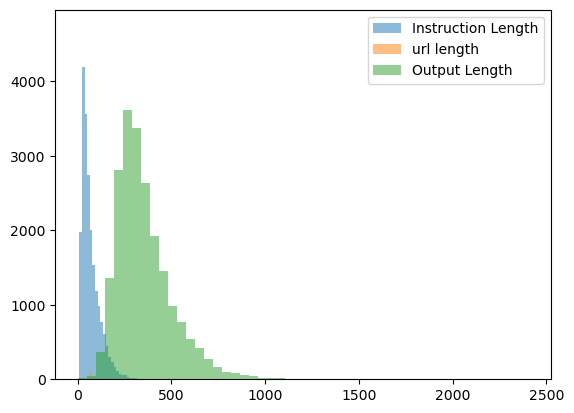

In [9]:
import matplotlib.pyplot as plt

# 문장 길이 분포 시각화
plt.hist(df['instruction_length'], bins=50, alpha=0.5, label='Instruction Length')
plt.hist(df['url_length'], bins=50, alpha=0.5, label='url length')
plt.hist(df['output_length'], bins=50, alpha=0.5, label='Output Length')
plt.legend(loc='upper right')
plt.show()

### 고유 단어 및 빈도수 분석

In [10]:
from collections import Counter

# 모든 문장을 단어로 분리
all_words = ' '.join(df['instruction']).split()

# 단어 빈도수 계산
word_freq = Counter(all_words)

# 가장 자주 등장하는 단어 10개
print('가장 자주 등장하는 단어 10개 : ', word_freq.most_common(10))
print('\n')
# 가장 드물게 등장하는 단어 10개
print('가장 드물게 등장하는 단어 10개 : ', word_freq.most_common()[:-11:-1])

가장 자주 등장하는 단어 10개 :  [('무엇인가요?', 6489), ('왜', 5465), ('어떤', 4402), ('궁금합니다.', 3568), ('어떻게', 3438), ('수', 3026), ('이유는', 2633), ('있는', 2286), ('있을까요?', 2265), ('있나요?', 1991)]


가장 드물게 등장하는 단어 10개 :  [('산모와', 1), ('과반수', 1), ('첫째주가', 1), ('정의되는가?', 1), ('우물이란', 1), ('구사하는', 1), ('충주만큼', 1), ('전국팔도에서도', 1), ('충주는', 1), ('옆비늘을', 1)]


## Chunk

- 정의: 청킹은 비구조화된 텍스트에서 구(phrase)나 "청크"를 추출하는 과정입니다. 토큰화가 텍스트를 개별 단어로 분할하는 반면, 청킹은 의미 있는 구나 문법 단위(예: 명사구, 동사구)를 추출하는 것을 목표로 합니다.

- 사용 사례:

명명된 엔터티 인식 (NER)

관계 추출

대용어 해소

- 예시:

입력: "빠른 갈색 여우가 게으른 개를 뛰어넘습니다."

청크: [("빠른 갈색 여우가", "NP"), ("뛰어넘습니다", "VP"), ("게으른 개를", "NP")]

- 장점:

토큰화에 비해 더 많은 문맥과 의미적 의미를 유지

텍스트 구조를 이해해야 하는 복잡한 NLP 작업에 유용

- 단점:

계산적으로 더 복잡

더 정교한 알고리즘 또는 모델이 필요할 수 있음

토큰화와 청킹은 모두 텍스트 분할을 위한 기술이지만, 다른 목적을 가지고 있으며 다른 NLP 작업에 유용합니다. 토큰화는 일반적으로 더 단순하고 빠르지만, 청킹은 더 깊은 이해를 제공합니다. 또한, 토큰화는 텍스트를 가장 작은 단위로 나누는 과정이며, 청킹은 이러한 토큰을 묶어서 더 큰 의미나 구조를 가진 단위로 만드는 과정입니다.

In [11]:
from random import randint
from itertools import chain
from functools import partial

# template dataset to add prompt to each sample
def template_dataset(data_point):
    full_prompt = prompter.generate_prompt(
        data_point["instruction"],
        data_point.get("input"),
        data_point["output"],
    )
    data_point['text'] = full_prompt
    return data_point

def chunk(sample, chunk_length=2048):
    # define global remainder variable to save remainder from batches to use in next batch
    global remainder
    # Concatenate all texts and add remainder from previous batch
    concatenated_examples = {k: list(chain(*sample[k])) for k in sample.keys()}
    concatenated_examples = {k: remainder[k] + concatenated_examples[k] for k in concatenated_examples.keys()}
    # get total number of tokens for batch
    batch_total_length = len(concatenated_examples[list(sample.keys())[0]])

    # get max number of chunks for batch
    if batch_total_length >= chunk_length:
        batch_chunk_length = (batch_total_length // chunk_length) * chunk_length

    # Split by chunks of max_len.
    result = {
        k: [t[i : i + chunk_length] for i in range(0, batch_chunk_length, chunk_length)]
        for k, t in concatenated_examples.items()
    }
    # add remainder to global variable for next batch
    remainder = {k: concatenated_examples[k][batch_chunk_length:] for k in concatenated_examples.keys()}
    # prepare labels
    result["labels"] = result["input_ids"].copy()
    return result

In [12]:
dataset = data['train'].shuffle()#.select(range(200))
dataset = dataset.map(template_dataset, remove_columns=list(dataset.features))

# empty list to save remainder from batches to use in next batch
remainder = {"input_ids": [], "attention_mask": []}

# tokenize and chunk dataset
lm_dataset = dataset.map(
    lambda sample: tokenizer(sample["text"]), batched=True, remove_columns=list(dataset.features)
).map(
    partial(chunk, chunk_length=1536),
    batched=True,
)

# Print total number of samples
print(f"Total number of samples: {len(lm_dataset)}")

Map:   0%|          | 0/21155 [00:00<?, ? examples/s]

Parameter 'function'=<function <lambda> at 0x7f9603d6ad40> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/21155 [00:00<?, ? examples/s]

Map:   0%|          | 0/21155 [00:00<?, ? examples/s]

Total number of samples: 3586


## chunking data 확인

In [13]:
df_lm = lm_dataset.to_pandas()
df_lm

,input_ids,attention_mask,labels
0,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
1,"[17, 2357, 276, 15296, 3709, 284, 272, 3711, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[17, 2357, 276, 15296, 3709, 284, 272, 3711, 2..."
2,"[6265, 1383, 768, 316, 5954, 365, 327, 827, 17...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[6265, 1383, 768, 316, 5954, 365, 327, 827, 17..."
3,"[105, 12, 339, 1203, 605, 450, 827, 17, 1252, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[105, 12, 339, 1203, 605, 450, 827, 17, 1252, ..."
4,"[7326, 309, 1466, 9715, 234, 1585, 20, 80, 838...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7326, 309, 1466, 9715, 234, 1585, 20, 80, 838..."
...,...,...,...
3581,"[17, 2357, 276, 15296, 3709, 284, 272, 3711, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[17, 2357, 276, 15296, 3709, 284, 272, 3711, 2..."
3582,"[2585, 363, 7007, 1522, 605, 272, 1579, 11139,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2585, 363, 7007, 1522, 605, 272, 1579, 11139,..."
3583,"[6, 3711, 29, 202, 852, 348, 285, 1333, 407, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[6, 3711, 29, 202, 852, 348, 285, 1333, 407, 2..."
3584,"[10157, 285, 454, 3967, 365, 327, 272, 2873, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[10157, 285, 454, 3967, 365, 327, 272, 2873, 3..."


In [14]:
# 'input_ids' 칼럼의 각 벡터의 길이를 새로운 칼럼 'input_ids_length'에 저장
df_lm['input_ids_length'] = df_lm['input_ids'].apply(len)

# 새로운 칼럼을 확인
df_lm

,input_ids,attention_mask,labels,input_ids_length
0,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",1536
1,"[17, 2357, 276, 15296, 3709, 284, 272, 3711, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[17, 2357, 276, 15296, 3709, 284, 272, 3711, 2...",1536
2,"[6265, 1383, 768, 316, 5954, 365, 327, 827, 17...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[6265, 1383, 768, 316, 5954, 365, 327, 827, 17...",1536
3,"[105, 12, 339, 1203, 605, 450, 827, 17, 1252, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[105, 12, 339, 1203, 605, 450, 827, 17, 1252, ...",1536
4,"[7326, 309, 1466, 9715, 234, 1585, 20, 80, 838...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[7326, 309, 1466, 9715, 234, 1585, 20, 80, 838...",1536
...,...,...,...,...
3581,"[17, 2357, 276, 15296, 3709, 284, 272, 3711, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[17, 2357, 276, 15296, 3709, 284, 272, 3711, 2...",1536
3582,"[2585, 363, 7007, 1522, 605, 272, 1579, 11139,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2585, 363, 7007, 1522, 605, 272, 1579, 11139,...",1536
3583,"[6, 3711, 29, 202, 852, 348, 285, 1333, 407, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[6, 3711, 29, 202, 852, 348, 285, 1333, 407, 2...",1536
3584,"[10157, 285, 454, 3967, 365, 327, 272, 2873, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[10157, 285, 454, 3967, 365, 327, 272, 2873, 3...",1536


In [15]:
# chunking 벡터의 최대 길이는 설정한 chunk_length windowing size로 고정됨
# 'input_ids_length' 칼럼의 최대값을 확인
max_value = df_lm['input_ids_length'].max()

print(f"The maximum length of 'input_ids' is {max_value}")

The maximum length of 'input_ids' is 1536


## Save dataset to S3

In [16]:
import sagemaker
import boto3
sess = sagemaker.Session()
region = boto3.Session().region_name
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
bucket = None
if bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=bucket)

print(f"SageMaker role arn: {role}")
print(f"SageMaker bucket: {sess.default_bucket()}")
print(f"SageMaker session region: {sess.boto_region_name}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
SageMaker role arn: arn:aws:iam::677146750822:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole
SageMaker bucket: sagemaker-ap-northeast-2-677146750822
SageMaker session region: ap-northeast-2


In [17]:
bucket_prefix = 'ko-llms/peft'
dataset_prefix = 'chunk-train'
s3_data_path = f"s3://{bucket}/{bucket_prefix}/{model_name}/dataset/{dataset_prefix}"
s3_pretrained_model_path = f"s3://{bucket}/{bucket_prefix}/huggingface-models/{model_name}/"
print(f"S3 data path: \n {s3_data_path}")
print(f"S3 pretrained model path: \n {s3_pretrained_model_path}")

S3 data path: 
 s3://sagemaker-ap-northeast-2-677146750822/ko-llms/peft/kullm-polyglot-12-8b-v2/dataset/chunk-train
S3 pretrained model path: 
 s3://sagemaker-ap-northeast-2-677146750822/ko-llms/peft/huggingface-models/kullm-polyglot-12-8b-v2/


In [18]:
num_debug_samples = 50
lm_dataset.save_to_disk(s3_data_path)
lm_dataset.select(range(num_debug_samples)).save_to_disk(dataset_prefix)
print(f"Number of samples for debugging: {num_debug_samples}")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


Saving the dataset (0/1 shards):   0%|          | 0/3586 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

Number of samples for debugging: 50


In [19]:
%store bucket_prefix dataset_prefix s3_data_path

Stored 'bucket_prefix' (str)
Stored 'dataset_prefix' (str)
Stored 's3_data_path' (str)
